# **Estimación de mínimos de energía en moléculas con VQE**

In [1]:
# pip install git+https://github.com/MIROptics/ECC2025.git

## Variational quantum eigensolver

Variational quantum eigensolver (VQE) [[1]](#Peruzzo2016) es un algoritmo que sirve para encontrar una cota superior para la mínima energía de un Hamiltoniano $\hat{H}$ (operador autoadjunto), es decir, el menor autovalor de $\hat{H}$. VQE es una herramienta útil en la búsqueda de una aproximación al estado basal, esto es, el autoestado asociado a la mínima energía. Para ello, VQE resuelve el problema

\begin{equation}
 \min_{|\psi\rangle}\frac{
 \langle\psi|\hat{H}|\psi\rangle}{\langle\psi|\psi\rangle}
\end{equation}

lo que significa que se busca un estado $|\psi\rangle$ que minimice el coeficiente de Rayleigh. Magnitud que puede ser eficientemente evaluada mediante un computador cuántico, y minimizada en un computador clásico. Para llevar a cabo esta tarea, se necesita aprender tres cosas:

1) Mapear el Hamiltoniano $\hat{H}$ a un computador cuántico.

2) Generar el estado $|\psi\rangle$ en un circuito cuántico paramétrico.

3) Evaluar el valor esperado del hamiltoniano $\hat{H}$.

## Primer Paso: Mapeo del Hamiltoneano

Hamiltonianos moleculares en segunda cuantización [[2]](#Tilly2022) pueden ser definidos como operadores fermiónicos mediante la función PySCFDriver() de la librería qiskit_nature.second_q.drivers.

In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
            atom = "H 0 0 0; H 0 0 0.735",
            basis="sto3g",
            charge=0,
            spin=0,
            unit=DistanceUnit.ANGSTROM,
            )


problem = driver.run()
hamiltonian  = problem.hamiltonian
fermionic_op = hamiltonian.second_q_op()
print(fermionic_op)

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.47189600728114184 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.47189600728114184 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.3322908651276482 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.3322908651276482 * ( +_0 +_3 -_3 -_0 )
+ 0.09046559989211572 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211572 * ( +_0 +_1 -_0 -_1 )
+ 0.09046559989211572 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211572 * ( +_0 +_3 -_2 -_1 )
+ 0.09046559989211572 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211572 * ( +_1 +_1 -_0 -_0 )
+ 0.09046559989211572 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211572 * ( +_1 +_3 -_2 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.34928686136600884 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.34928686136600884 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.3322908651276482 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507

Para guardar dicho Hamiltoniano se hace uso de la función json.dump() de la librería json.

In [3]:
# Guardar operador fermiónico
import json

fermionic_op_dict = fermionic_op.__dict__

with open("fermionic_op1.json", "w") as outfile:
    json.dump(fermionic_op_dict, outfile)

Adicionalmente, mediante la función json.load() se puede cargar un Hamiltoniano previamente guardado.

In [4]:
# Cargar operador Fermiónico
from qiskit_nature.second_q.operators.fermionic_op import FermionicOp
import json

infile = open('fermionic_op1.json')
fermionic_op_dict = json.load(infile)
fermionic_op = FermionicOp( fermionic_op_dict['_data'] )
print( fermionic_op )

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.47189600728114184 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.47189600728114184 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.3322908651276482 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.3322908651276482 * ( +_0 +_3 -_3 -_0 )
+ 0.09046559989211572 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211572 * ( +_0 +_1 -_0 -_1 )
+ 0.09046559989211572 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211572 * ( +_0 +_3 -_2 -_1 )
+ 0.09046559989211572 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211572 * ( +_1 +_1 -_0 -_0 )
+ 0.09046559989211572 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211572 * ( +_1 +_3 -_2 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.34928686136600884 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.34928686136600884 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.3322908651276482 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507

Para simular sistemas fermiónicos en computadores cuánticos, los operadores fermiónicos deben ser codificados en redes de qubits. Para ello, comúnmente se utiliza la
transformación de Jordan-Wigner [[3]](#JW1928) (concretamente su transformación inversa) para convertir un Hamiltoniano fermiónico en un Hamiltoniano de spín. Esto se ejecuta en Qiskit mediante la función JordanWignerMapper() de la libreria qiskit_nature.second_q.mappers.

In [5]:
from qiskit_nature.second_q.mappers import JordanWignerMapper
mapper = JordanWignerMapper()
qubit_op = mapper.map(fermionic_op)
print( qubit_op )

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.17218393+0.j,
 -0.22575349+0.j,  0.12091263+0.j,  0.16892754+0.j,  0.16614543+0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])


## Segundo Paso: Generar el ansatz

Nos referimos por ansatz a un circuito cuántico paramétrico que determina los estados cuánticos $|\psi({\theta})\rangle = U({\theta})|0\rangle$ considerados en la minimización de la energía. Los estados ansatz están caracterizados por secuencias de capas de compuertas paramétricas de un qubit como por ejemplo $Rx(\theta_1)R_y(\theta_2)$, las cuales se repiten un cierto número de veces, y entre cada repetición se encuentra una compuerta que entrelaza los qubits.

![Ansatz](https://raw.githubusercontent.com/MIROptics/ECC2025/refs/heads/master/talleres/05_Estimacion_minimimos_de_energia_VQE/img/Ansatz.png)

Para crear este circuito paramétrico (hardware eficiente [[2]](#Tilly2022)), debemos utilizar la función ParameterVector() de qiskit. Esta, crea un conjunto de variables simbólicas que son utilizadas como argumento en las puertas del ansatz.

**Instrucción**: Escribir una función que genere el ansatz requerido, para un número de qubits y de capas indicadas (Para el ejemplo se utiliza 4 y 2 respectivamente).



In [17]:
# Importar librerías necesarias
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def Hardware_Efficient_Ansatz(nqubits,reps):

  theta   = ParameterVector( '$\\theta$', 2*nqubits*(reps+1) )
  ansatz = QuantumCircuit(nqubits)

  ## completar ##
  # Compuertas iniciales
  j = 0
  for q in range(nqubits):
    ansatz.rx(theta[j], q)
    ansatz.ry(theta[j+1], q)
    j+=2

  # Layers
  for _ in range(reps):
    for q in range(0, nqubits):
      if q < nqubits - 1:
        ansatz.cx(q, q+1)
      ansatz.rx(theta[j], q)
      ansatz.ry(theta[j+1], q)
      j+=2


  return ansatz

Luego, podemos generar el ansatz del ejemplo:

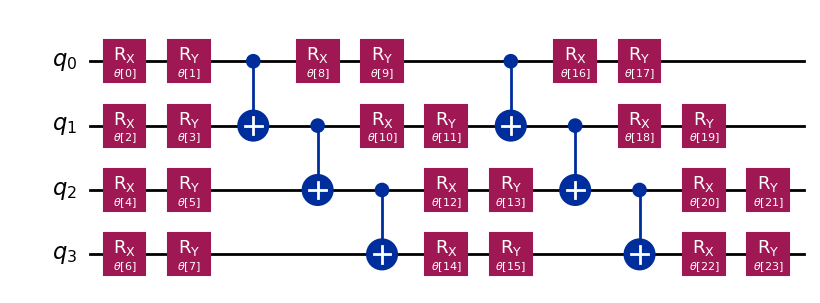

In [18]:
nqubits = fermionic_op.num_spin_orbitals
reps    = 2
ansatz = Hardware_Efficient_Ansatz(nqubits,reps)
ansatz.draw('mpl')

## Tercer Paso: Evaluar el valor de expectacion y minimizar la energía

Para estimar valores esperados de circuitos cuánticos y observables, se utiliza la función Estimator() de la librería qiskit_aer.primitives. Luego, se puede minimizar la energía mediante cualquier optimizador clásico, por ejemplo la función SPSA() de la librería qiskit.algorithms.optimizers.

**Instrucción**: Estudie la documentación de <a href="https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Estimator#run">qiskit.algorithms.optimizers</a> de Qiskit, para ejecutar el método .run() de la función Estimator(). Esto es, completar los tres inputs faltantes en  

    estimator.run( , , , shots=100 )



In [19]:
# Importar librerías necesarias
import numpy as np
from qiskit_aer.primitives import Estimator

estimator = Estimator()
theta = np.zeros(ansatz.num_parameters)

job = estimator.run( ansatz, qubit_op, theta, shots=100 )

values = job.result().values
print(values) # [-0.0081419]

[-0.00542794]


**Intrucción**: Revise la documentación de <a href="https://docs.quantum.ibm.com/api/qiskit/0.40/qiskit.algorithms.optimizers.Optimizer">Optimizer</a> de Qiskit, para realizar la minimización de la función objetivo. Esto es, completar los inputs de
    optimizer.minimize( , )

In [23]:
from qiskit_algorithms.optimizers import SPSA

data_per_iter = []
callback      = lambda evals_num, params, fun_value, stepsize, step_accepted : data_per_iter.append( fun_value )

maxiter   = 200
optimizer = SPSA( maxiter=maxiter, callback=callback )

obj_func = lambda theta : estimator.run( ansatz,
                                        qubit_op,
                                        theta,
                                        shots=100 ).result().values

initial_params = np.random.randn(ansatz.num_parameters)

results = optimizer.minimize( obj_func, theta)
print(results)

{   'fun': array([-1.59947234]),
    'jac': None,
    'nfev': 600,
    'nit': 200,
    'njev': None,
    'x': array([ 0.02539236, -3.17307056, -5.73046882,  3.03772446, -4.68837195,
        5.04816857,  3.23430666, -1.5848861 ,  6.12985117, -6.82576591,
       -1.72370329, -0.79644727, -1.63395786,  1.7508115 , -8.34134307,
       -5.94748334,  2.73586845, -2.92287263, -7.74740864, -0.25106245,
       -2.8939423 , -4.93148852,  0.39259433, -1.78505801])}


**Observación**: Observe el output de optimizer.minimize( , ) y vea como obtener el valor mínimo y los parámetros que determinan el estado de mínima energía. Además, note que en la variable *data_per_iter* se guardó los valores de la minimización en cada iteración.

## Analisis de resultados

Para determinar la performance (convergencia y velocidad de convergencia) del optimizador en la minimización de la energía, se necesita un valor mínimo de referencia. Para este ejemplo pedagógico, podemos hacer "trampa" y calcular dicho mínimo clásicamente al diagonalizar el Hamiltoniano $\hat{H}$.


In [24]:
from qiskit_algorithms.eigensolvers import NumPyEigensolver

classical_solver  = NumPyEigensolver()
results_classical = classical_solver.compute_eigenvalues( qubit_op )
min_of_energy     = results_classical.eigenvalues
print(min_of_energy)

[-1.85727503]


Luego podemos graficar los valores obtenidos mediante la minimización.

Text(0, 0.5, 'Energía')

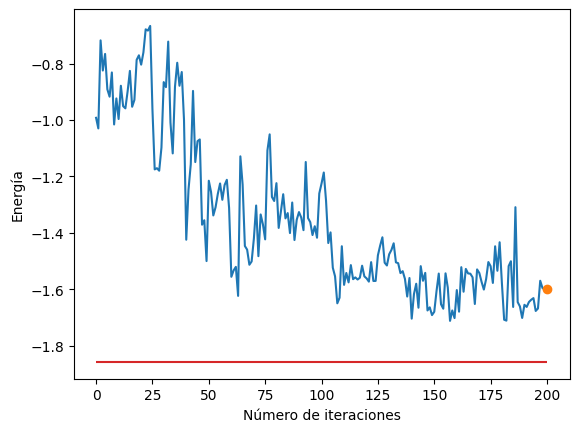

In [25]:
import matplotlib.pyplot as plt

plt.plot( data_per_iter )
plt.plot( [maxiter], [results.fun], 'o' )
plt.hlines( min_of_energy, 0, maxiter, color='tab:red' )
plt.xlabel('Número de iteraciones')
plt.ylabel('Energía')

## Implementación de VQE

Para realizar una implementación de VQE solo resta juntar los tres pasos anteriores.

**Instruccion**: Escribir una función que entregue una estimación del mínimo de la energía y los parámetros $\theta$ que determinan el estado que la minimiza. Para ello debe entregarse al programa el número de layers que considera el ansatz y el número de iteraciones del optimizador clásico (SPSA en este caso).

In [55]:
## Importamos todas las librerias
#pip install git+https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.optimizers import QNSPSA
from qiskit.primitives import Sampler

def VQE(qubit_op, reps, maxiter, optimizer_obj = 'SPSA'):

    # Definir el Ansatz
    nqubits = int(np.log2(qubit_op.dim[1]))
    ansatz = Hardware_Efficient_Ansatz(nqubits, reps)

    # realizar la optimización
    estimator = Estimator()
    obj_func = lambda theta : estimator.run( ansatz,
                                            qubit_op,
                                            theta,
                                            shots=100 ).result().values

    data_per_iter = []
    callback      = lambda evals_num, params, fun_value, stepsize, step_accepted : data_per_iter.append( fun_value )
    if optimizer_obj == 'SPSA':
        optimizer = SPSA( maxiter=maxiter, callback=callback )
    else:
        fidelity = QNSPSA.get_fidelity( circuit = ansatz, sampler = Sampler() )
        optimizer = QNSPSA( fidelity=fidelity, maxiter=maxiter, callback=callback )
        
    initial_params = np.random.randn(ansatz.num_parameters)
    results = optimizer.minimize( obj_func, initial_params)
    print(results)

    return results.fun, results.x, data_per_iter


**Instrucción:** Cargue el Hamiltoniano generado previamente y llame a la función VQE. Finalmente, realice un gráfico que muestre la estimación de la energía mínima entregada por VQE en cada iteración.

/tmp/ipykernel_103453/2512241345.py:24: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, reps, maxiter)
/tmp/ipykernel_103453/2512241345.py:24: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, reps, maxiter)


{   'fun': array([-1.83968196]),
    'jac': None,
    'nfev': 600,
    'nit': 200,
    'njev': None,
    'x': array([ 1.28431496e+00,  3.01299180e+00, -4.13439250e-01,  1.85314682e+00,
       -3.07358365e+00, -4.45684496e+00, -2.54663110e-03, -1.57677640e+00,
        1.32754674e+00, -3.24831312e+00,  2.87324966e+00,  1.17208666e+00,
       -2.33276020e-01,  7.51440842e-01,  4.52106033e-01, -8.44164945e-02,
       -3.28232026e+00,  5.00328046e-01,  2.91606265e+00,  2.59314829e+00,
       -1.00913329e-01, -7.94741399e-01, -8.88143754e-01,  1.59946940e+00])}


Text(0, 0.5, 'Energía')

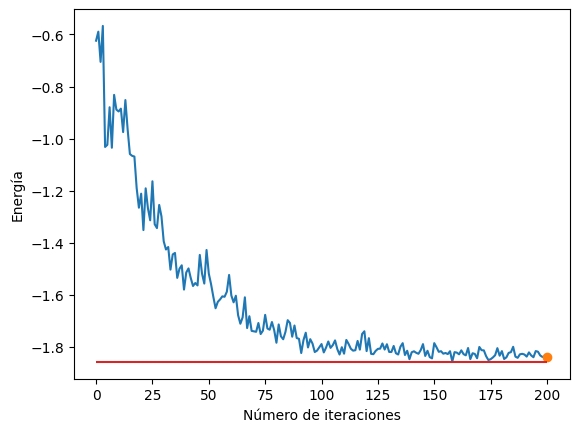

In [56]:
# Cargar librerias en caso de no haberlo hecho antes
from qiskit_nature.second_q.operators.fermionic_op import FermionicOp
import json
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms.eigensolvers import NumPyEigensolver

## Paso 1: Definir Hamiltoniano
# Cagar Hamiltoneano

import json
infile = open('fermionic_op1.json')
fermionic_op_dict = json.load(infile)
fermionic_op = FermionicOp( fermionic_op_dict['_data'] )

# Mapear Hamiltoniano
from qiskit_nature.second_q.mappers import JordanWignerMapper
mapper = JordanWignerMapper()
qubit_op = mapper.map(fermionic_op)

## Implementacion (LLamar a función VQE)
reps = 2
maxiter = 200

estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, reps, maxiter)

##  Analisis de resultados

# Obtener valor de referencia (Esto no se puede hacer siempre. Aqui se puede por que es un ejemplo simple)
from qiskit_algorithms.eigensolvers import NumPyEigensolver

classical_solver  = NumPyEigensolver()
results_classical = classical_solver.compute_eigenvalues( qubit_op )
min_of_energy     = results_classical.eigenvalues

# Plotear resultados
import matplotlib.pyplot as plt

plt.plot( data_per_iter )
plt.plot( [maxiter], [estimated_energy], 'o' )
plt.hlines( min_of_energy, 0, maxiter, color='tab:red' )
plt.xlabel('Número de iteraciones')
plt.ylabel('Energía')

## Tarea 1:

Comparar el funcionamiento de la función VQE al considerar distintos números de layers.

/tmp/ipykernel_103453/1636081388.py:6: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, capas[k], maxiter, 'QNSPSA')
/tmp/ipykernel_103453/1636081388.py:6: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, capas[k], maxiter, 'QNSPSA')
/tmp/ipykernel_103453/2638406995.py:31: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  fidelity = QNSPSA.get_fidelity( circuit

{   'fun': array([-1.25768723]),
    'jac': None,
    'nfev': 1401,
    'nit': 200,
    'njev': None,
    'x': array([ 3.22214165,  0.16948935,  0.46462224, -5.54067507,  6.60539207,
        2.94137142,  2.12494725, -0.61152893,  5.45074891, -0.30861702,
       -9.21108301,  5.40154675,  2.1875225 ,  0.89065609,  1.10650161,
       -8.14670485])}


/tmp/ipykernel_103453/1636081388.py:6: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, capas[k], maxiter, 'QNSPSA')
/tmp/ipykernel_103453/1636081388.py:6: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, capas[k], maxiter, 'QNSPSA')
/tmp/ipykernel_103453/2638406995.py:31: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  fidelity = QNSPSA.get_fidelity( circuit

{   'fun': array([-1.31923267]),
    'jac': None,
    'nfev': 1401,
    'nit': 200,
    'njev': None,
    'x': array([ 1.26027666, -4.7424851 , -6.40795302, -4.30803033,  1.21611909,
        2.71247651,  0.2249218 ,  4.27306212, -5.02533466,  3.69102907,
       -0.44356773,  4.54262879, -0.75532358, -5.24072745, -0.47796327,
        0.63816397,  2.37537551, -5.2743892 , -1.1557692 , -6.19795842,
        9.11557878, -0.66327459,  1.34920917,  1.412896  ])}


/tmp/ipykernel_103453/1636081388.py:6: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, capas[k], maxiter, 'QNSPSA')
/tmp/ipykernel_103453/1636081388.py:6: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, capas[k], maxiter, 'QNSPSA')
/tmp/ipykernel_103453/2638406995.py:31: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  fidelity = QNSPSA.get_fidelity( circuit

{   'fun': array([-0.87659851]),
    'jac': None,
    'nfev': 1401,
    'nit': 200,
    'njev': None,
    'x': array([  0.41055196,  -1.00001194,  -9.72804239,   4.08919147,
         4.77174472,  24.76133062,   7.29660539,  -7.53444277,
       -13.95566695,  -4.1485311 ,   1.37875718,   6.52370438,
         2.59908258,  -4.51310922,   0.6089061 ,   1.77892598,
         7.49254941,   3.52687842,  15.81645454,  -4.36519551,
         8.03844297,   9.49528541,  -7.44226737,   1.2698282 ,
        -4.67889771,  -3.60027748,   3.80066015, -13.30577849,
         7.7650799 ,   2.08909167,  -0.77009472, -12.87986127])}


/tmp/ipykernel_103453/1636081388.py:6: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, capas[k], maxiter, 'QNSPSA')
/tmp/ipykernel_103453/1636081388.py:6: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, capas[k], maxiter, 'QNSPSA')
/tmp/ipykernel_103453/2638406995.py:31: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  fidelity = QNSPSA.get_fidelity( circuit

{   'fun': array([-0.8620464]),
    'jac': None,
    'nfev': 1401,
    'nit': 200,
    'njev': None,
    'x': array([-0.54881752,  3.45644344,  3.23487011, -3.02514839,  4.0344392 ,
       -5.05630378,  2.2898166 ,  3.28341046, -1.91858354, -0.41761253,
       -2.15481564, -2.05721059, -1.76597341,  2.0659321 ,  1.90249814,
       -1.46999941, -3.44843625,  1.48837851,  2.48983724,  1.88114177,
       -6.11882985,  2.50134487,  1.30775468, -0.01531402,  5.63101808,
        4.30964061,  4.87053849, -0.28065195,  3.01075844,  1.42837108,
       -5.86843115,  3.91149363, -1.09712951,  1.37850513,  4.72146197,
       -4.52013016,  0.93954854,  2.29685195, -2.16839741, -1.4342199 ])}


/tmp/ipykernel_103453/1636081388.py:6: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, capas[k], maxiter, 'QNSPSA')
/tmp/ipykernel_103453/1636081388.py:6: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, capas[k], maxiter, 'QNSPSA')
/tmp/ipykernel_103453/2638406995.py:31: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  fidelity = QNSPSA.get_fidelity( circuit

{   'fun': array([-1.25925941]),
    'jac': None,
    'nfev': 1401,
    'nit': 200,
    'njev': None,
    'x': array([ 1.28828484,  5.41010177, -0.63356077,  2.75358082,  2.53006143,
       -2.52577516,  1.03708262,  4.22946154,  1.30316672, -1.46161456,
       -1.122393  ,  2.2060113 , -2.97363579,  0.49989252,  1.72470701,
       -0.47021181, -3.65135192, -0.0824156 ,  1.54883155, -1.95067815,
       -1.12017167,  1.64986735, -1.64096907, -1.24461702,  0.45718981,
        0.14179843, -1.87937404, -1.15261588,  2.00563798, -2.64403521,
        0.12448824,  1.08366319, -1.55080191, -2.91670687,  1.3484935 ,
       -2.62871256, -0.1371468 ,  3.13088593, -0.39159653, -1.25234915,
       -1.68157964, -1.00171887,  4.34857639,  0.44546886, -1.61836783,
        1.74883757,  3.86642798, -0.20621506])}


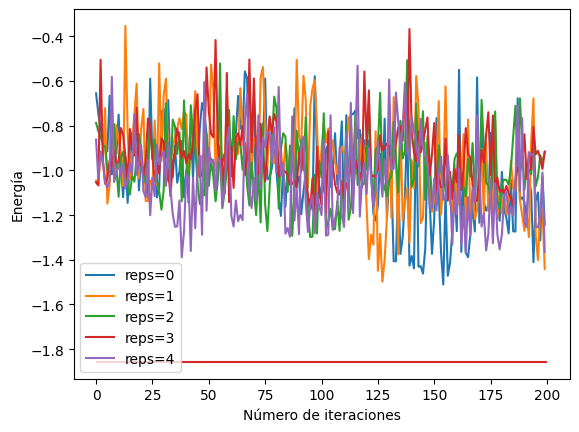

In [58]:
results_per_rep = []
capas = [1, 2, 3, 4, 5]
maxiter = 200

for k in range(len(capas)):
    estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, capas[k], maxiter, 'QNSPSA')
    plt.plot( data_per_iter, label='reps={}'.format(k) )

plt.hlines( min_of_energy, 0, maxiter, color='tab:red' )
plt.xlabel('Número de iteraciones')
plt.ylabel('Energía')
plt.legend()

## Tarea 2:

Cambiar el optimizador clásico utilizado en la función VQE (SPSA). Para ello revise la documentación de Qiskit respecto a <a href="https://docs.quantum.ibm.com/api/qiskit/qiskit.algorithms.optimizers">optimizadores</a>. Por ejemplo, para utilizar el optimizador QN-SPSA se debe cargar las funciones

    from qiskit.algorithms.optimizers import QNSPSA
    from qiskit.primitives import Sampler

 y remplazar el optimizador utilizado, mediante el siguiente segmento de código:
      
    fidelity = QNSPSA.get_fidelity( ansatz, Sampler() )
    optimizer = QNSPSA( fidelity=fidelity, maxiter=maxiter, callback=callback )

Observacion: Para este ejemplo, el optimizador QN-SPSA funciona peor que SPSA, requiriendo cerca de 1000 iteraciones para converger.   

## Tarea 3:

Ejecutar la implementación de VQE para simular la partícula de LiH. Para ello, utilice el operador fermiónico guardado en la variable <a href="https://drive.google.com/file/d/1yaw3kj-e4Du4cZh2b3DNRsQhyjnZ2WF2/view?usp=drive_link">fermionic_op2.json</a>. Además, determine el número de layers adecuado a considerar en el ansatz y el optimizador más favorable para alcanzar una buena estimación del mínimo de la energía.


## Referencias

<a id='Peruzzo2016'>[1]</a> Peruzzo, A., McClean, J., Shadbolt, P. et al. A variational eigenvalue solver on a photonic quantum processor. *Nat Commun 5*, 4213 (2014). https://doi.org/10.1038/ncomms5213

<a id='Tilly2022'>[2]</a> Jules Tilly, Hongxiang Chen, Shuxiang Cao, Dario Picozzi, Kanav Setia, Ying Li, Edward Grant, Leonard Wossnig, Ivan Rungger, George H. Booth, Jonathan Tennyson,
The Variational Quantum Eigensolver: A review of methods and best practices,
*Physics Reports*,
Volume 986,
2022,
Pages 1-128,
ISSN 0370-1573,
https://doi.org/10.1016/j.physrep.2022.08.003.

<a id='JW1928'>[3]</a> Jordan, P., Wigner, E. Über das Paulische Äquivalenzverbot. Z. *Physik* 47, 631–651 (1928). https://doi.org/10.1007/BF01331938

## Contactos:

Mario Muñoz <br>
Doctor en Ciencias Aplicadas Mención en Ingeniería Matemática, Universidad de Concepción <br>
Postdoc, Fundación Getulio Vargas, Rio de Janeiro, Brazil <br>
munozmunozmarioalejandro@gmail.com

Luciano Pereira <br>
Doctor en Ciencias Física, IFF-CSIC, Spain <br>
luciano.pereira.valenzuela@gmail.com